In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from mod_macd_utils.macd import get_macd_signal_line, get_signal_macd_crossover

In [2]:
from mod_my_utils.read_write_data import *

### Read Data

In [7]:
symbol = 'HDFC.NS'
data_source = 'yahoo'
start_date = date(2020, 1, 1)
end_date = date.today()
print(start_date)
print(end_date)
stock_data = get_price_yahoo(symbol=symbol, data_source=data_source, start_date=start_date, end_date=end_date)
stock_data.head()

2020-01-01
2021-12-19
stock name:  HDFC.NS


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-01,2438.500000,2409.000000,2418.00,2433.949951,945874.0,2359.273682
2020-01-02,2472.750000,2422.000000,2430.00,2466.399902,1701396.0,2390.728027
2020-01-03,2466.399902,2441.800049,2455.00,2454.449951,1963923.0,2379.144531
2020-01-06,2445.000000,2371.399902,2428.00,2384.100098,2656731.0,2310.953125
2020-01-07,2428.800049,2380.199951,2401.25,2415.050049,3771992.0,2340.953369


In [3]:
stock_name = "aapl"
folder_name = "data/"
stock_data = get_price_csv(folder_name=folder_name, symbol=stock_name, index_col="Date")

stock name:  aapl


In [4]:
data = stock_data[['Adj. Close']].copy()
data.columns = ['price']
data.head()

,price
Date,
2007-12-03,22.986003
2007-12-04,23.108091
2007-12-05,23.839335
2007-12-06,24.411582
2007-12-07,24.970258


### MACD

In [5]:
short_window = 80
long_window = 100
signal_window = 20

In [6]:
macd_signal_line = get_macd_signal_line(data, short_window=short_window, long_window=long_window, signal_window=signal_window)

In [7]:
signals = get_signal_macd_crossover(macd_signal_line, long_window)

<AxesSubplot:xlabel='Date'>

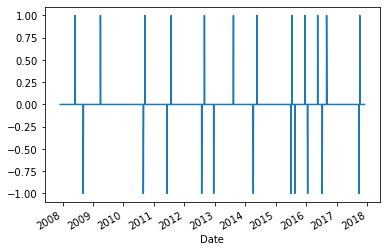

In [8]:
signals.buy_sell.plot()

In [9]:
from mod_portfolio_utils.portfolio import get_stock_portfolio

In [10]:
portfolio = get_stock_portfolio(signals=signals)

In [11]:
portfolio.head()

,holdings_in_stock,cash,total
Date,,,
2007-12-03,0.0,100000.0,100000.0
2007-12-04,0.0,100000.0,100000.0
2007-12-05,0.0,100000.0,100000.0
2007-12-06,0.0,100000.0,100000.0
2007-12-07,0.0,100000.0,100000.0


<AxesSubplot:xlabel='Date'>

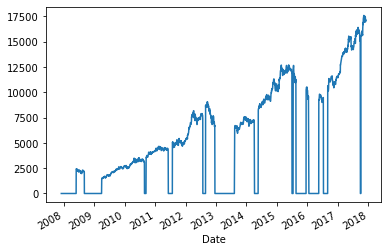

In [12]:
portfolio.holdings_in_stock.plot()

<AxesSubplot:xlabel='Date'>

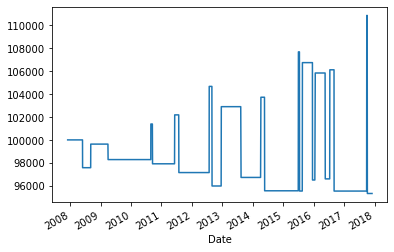

In [13]:
portfolio.cash.plot()

<AxesSubplot:xlabel='Date'>

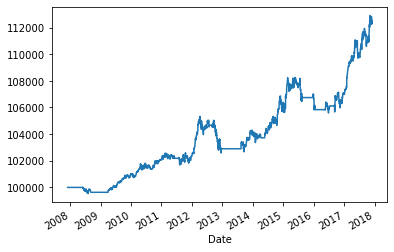

In [14]:
portfolio.total.plot()

### MA strategy and portfolio

In [15]:
from mod_backtest_utils.backtest import Strategy, Portfolio

### Strategy

In [16]:
# ma_cross.py
class MovingAverageCrossStrategy(Strategy):
    """
    Requires:
    symbol: A stock symbol on which to form a strategy
    bars: A DataFrame of bars for the above symbol
    short_window: Looback period for short moving average
    long_window: Lookback period for long movign average
    signal_window: Lookback period for signal line
    """
    
    def __init__(self, symbol, bars, short_window= 80, long_window= 100, signal_window = 20):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window
        self.signal_window = signal_window
        
    def generate_signals(self):
        """
        Returns the DataFrame of symbols containing the signals to go long, short or hold (1, -1, 0)
        """
        signals = pd.DataFrame(index=self.bars.index)
        signals['buy_sell'] = 0.0
        signals['price'] = self.bars['price']
        
        # Create the set of short and long simple moving average over the respective periods
        signals['SMA'] = signals['price'].rolling(self.short_window, min_periods=1).mean()
        signals['LMA'] = signals['price'].rolling(self.long_window, min_periods=1).mean()
        
        # Create a signal (invested or not invested) when the short moving average cross the 
        # long moving average, but only for the period greater than the long moving average window
        signals['buy_sell'][self.long_window:] = np.where(signals['SMA'][self.long_window:]
                                                        > signals['LMA'][self.long_window:], 1.0, 0.0)
        
        # Take the difference of the signals in order to generate actual trading orders
        signals['buy_sell'] = signals['buy_sell'].diff()
        
        return signals[['price', 'buy_sell']]
        

In [17]:
# ma_cross.py 
class MovingAverageCrossStrategy(Strategy):
    
    """ 
    Requires: 
    symbol: A stock symbol on which to form a strategy 
    bars: A DataFrame of bars for the above symbol 
    short_window: Looback period for short moving average 
    long_window: Lookback period for long movign average 
    signal_window: Lookback period for signal line 
    """
    
    def __init__(self, symbol, bars, short_window= 80, long_window= 100, signal_window = 20): 
        self.symbol = symbol 
        self.bars = bars 
        self.short_window = short_window 
        self.long_window = long_window
        self.signal_window = signal_window
        
        
    def generate_signals(self): 
        """ 
        Returns the DataFrame of symbols containing the signals to go long, short or hold (1, -1, 0)
        """ 
        signals = pd.DataFrame(index=self.bars.index) 
        signals['buy_sell'] = 0.0 
        signals['price'] = self.bars['price'] 

        # Create the set of short and long simple moving average over the respective periods 
        signals['SMA'] = signals['price'].rolling(self.short_window, min_periods=1).mean() 
        signals['LMA'] = signals['price'].rolling(self.long_window, min_periods=1).mean() 

        # Create a signal (invested or not invested) when the short moving average cross the 
        # long moving average, but only for the period greater than the long moving average window 
        signals['buy_sell'][self.long_window:] = np.where(signals['SMA'][self.long_window:] 
        > signals['LMA'][self.long_window:], 1.0, 0.0) 

        # Take the difference of the signals in order to generate actual trading orders 
        signals['buy_sell'] = signals['buy_sell'].diff() 

        return signals[['price', 'buy_sell']]

In [18]:
help(MovingAverageCrossStrategy)

Help on class MovingAverageCrossStrategy in module __main__:

class MovingAverageCrossStrategy(mod_backtest_utils.backtest.Strategy)
 |  MovingAverageCrossStrategy(symbol, bars, short_window=80, long_window=100, signal_window=20)
 |  
 |  Requires: 
 |  symbol: A stock symbol on which to form a strategy 
 |  bars: A DataFrame of bars for the above symbol 
 |  short_window: Looback period for short moving average 
 |  long_window: Lookback period for long movign average 
 |  signal_window: Lookback period for signal line
 |  
 |  Method resolution order:
 |      MovingAverageCrossStrategy
 |      mod_backtest_utils.backtest.Strategy
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, symbol, bars, short_window=80, long_window=100, signal_window=20)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  generate_signals(self)
 |      Returns the DataFrame of symbols containing the signals to go long, short or hold (1, -1, 0)
 |  
 |  --

In [19]:
stock_data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2007-12-03,181.86,184.14,177.70,178.8600,34338200.0,0.0,1.0,23.371545,23.664556,22.836927,22.986003,240367400.0
2007-12-04,177.15,180.90,176.99,179.8100,27635700.0,0.0,1.0,22.766244,23.248171,22.745682,23.108091,193449900.0
2007-12-05,182.89,186.00,182.41,185.5000,31871500.0,0.0,1.0,23.503914,23.903592,23.442227,23.839335,223100500.0
2007-12-06,186.19,190.10,186.12,189.9528,32136100.0,0.0,1.0,23.928010,24.430500,23.919014,24.411582,224952700.0
2007-12-07,190.54,194.99,188.04,194.3000,38073800.0,0.0,1.0,24.487046,25.058933,24.165761,24.970258,266516600.0


In [20]:
symbol = 'AAPL'
macd_signal_strategy = MovingAverageCrossStrategy(symbol, data)

In [21]:
# print(macd_signal_strategy)

In [22]:
# help(macd_signal_strategy)

In [23]:
signals = macd_signal_strategy.generate_signals()

<AxesSubplot:xlabel='Date'>

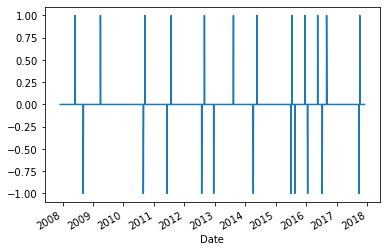

In [24]:
signals.buy_sell.plot()

### Portfolio

In [25]:
# ma_cross.py

class MarketOnPricePortfolio(Portfolio):
    """
    Encapsulates the notion of a portfolio of positions based on a set of signals as provided by a Strategy
    
    Requires:
    symbol: A stock symbol which forms the basis of the portfolio.
    signals: A pandas DataFrame of signals (1, 0, -1) and price for each symbol.
    Initial_capital: the amount in cash at the start of the portfolio.
    """
    
    def __init__(self, symbol, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index= self.signals.index).fillna(0.0)
        # Buy a 100 shares and accumulate position
        positions[self.symbol] = 100 * self.signals['buy_sell'].cumsum() 
        return positions
    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.signals.index)
        # Initialize the portfolio with value owned 
        portfolio[self.symbol] = self.positions[self.symbol].multiply(signals['price'], axis=0)
        pos_diff = 100 * self.signals[['buy_sell']]
        # add holding to portfolio
        portfolio['holdings'] = (self.positions.multiply(signals['price'], axis=0)).sum(axis=1)
        # Add `cash` to portfolio
        portfolio['cash'] = self.initial_capital - (pos_diff.multiply(self.signals['price'], axis=0)).sum(axis=1).cumsum()   
        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        # return the portfolio
        return portfolio[['holdings', 'cash', 'total']]


In [26]:
portfolio_ma = MarketOnPricePortfolio(symbol=symbol, signals=signals)

In [27]:
macd_portfolio = portfolio_ma.backtest_portfolio()

<AxesSubplot:xlabel='Date'>

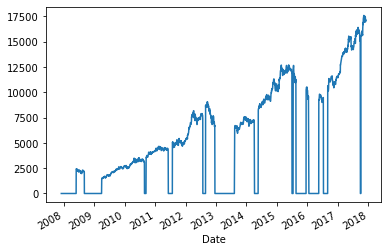

In [28]:
macd_portfolio.holdings.plot()

<AxesSubplot:xlabel='Date'>

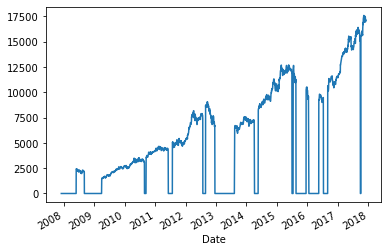

In [29]:
macd_portfolio.holdings.plot()

### compare

<AxesSubplot:xlabel='Date'>

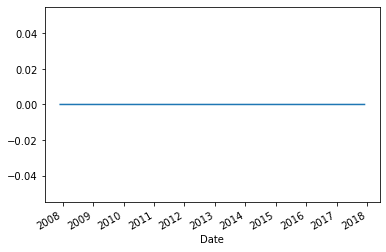

In [30]:
(portfolio.holdings_in_stock - macd_portfolio.holdings).plot()

<AxesSubplot:xlabel='Date'>

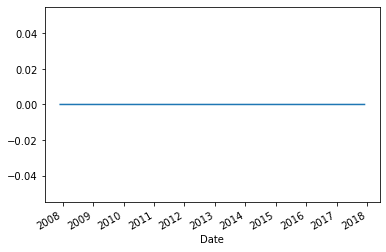

In [31]:
(portfolio.cash - macd_portfolio.cash).plot()

<AxesSubplot:xlabel='Date'>

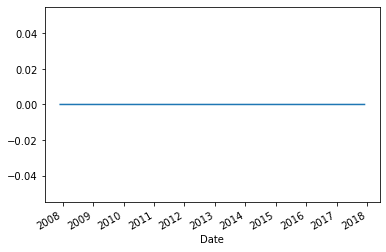

In [32]:
(portfolio.total - macd_portfolio.total).plot()